## OCNT-DMSLIB-1 Assay, Chunk 10

This report documents the processing of the first complete DMS assay covering chunk 10 of TYK2. The new sequencing run with expressed barcodes is `221110_VH00964_9_AAAW57KHV` which includes 3 replicates each of 4 sample groups, for a total of 12 samples. The four sample groups correspond to two clones (c1 and c8) in each of two conditions (0 or 100 U/mL cytokine treatment). The barcode map is from sequencing run `220824_VH00964_6_AAAMJF3HV` and is the combination of 10C and 10D after removing any barcodes detected in both (experimentally, they should be non-overlapping).

1. [Barcode Sequencing Quality Control](#part1)
2. [Statistical Models](#part2)
3. [Summary Statistics](#part3)
    - [Within Condition](#part3a)
    - [Between Conditions](#part3b)
4. [Visualization and Interpretation](#part4)

### Barcode Sequencing Quality Control <a name="part1"></a>

To associate barcodes with oligos, we need to use a barcode map sequenced in a previous 2x150 run. We use the combination of the maps from `10C` and `10D`, after subtracting any barcodes that are detected in both. This returns approximately 5.5 million unique, oligo-barcode pairs that map to perfect oligos.

The expressed barcode 1x26 samples are sequenced to 65-80 million reads per sample. In all samples, the large majority of barcodes were previously observed in a barcode mapping run, though frequently not associated with a perfect oligo (as expected). In general, approximately 60-65% of the raw reads in each sample were matched to a perfect, usable oligo. Here, "subthreshold" means that the barcode failed one of the filters applied during barcode mapping (>3 reads with >75% purity in both replicates). These categories are **non-overlapping** and account for all observed barcodes in each sample:

In [62]:
library(magrittr)
library(data.table)
library(ggpubr)
library(scales)
library(UpSetR)
library(scico)
library(knitr)
library(fs)
library(patchwork)
library(glmmTMB)
library(tidyverse)

scale_fill_scico_mid <- function(..., mid = 0, alpha = NULL, begin = 0, end = 1, direction = 1, reverse = TRUE ,palette = "broc") {
  if (!requireNamespace("ggplot2", quietly = TRUE)) {
        stop("ggplot2 is required for this functionality", call. = FALSE)
  }
  force(mid)
  ggplot2::continuous_scale(
    aesthetics = "fill", 
    scale_name = "gradient2",
    palette = scales::gradient_n_pal(
      colours = scico(256, alpha, begin, end, direction, palette), 
      values = NULL, space = "Lab"),
    guide="colourbar",
    rescaler = function(x, to = c(0, 1), from = range(x, na.rm = TRUE)) {
      scales::rescale_mid(x, to, from, mid)
    },
    ...
  )
}

In [8]:
bcs_all <- fread("../pipeline/batch1/10CD.bcmap-join-bcs.tsv", col.names = "bc")
bcs_filt <- fread("../pipeline/batch1/10CD.bcmap-filtered-bcs.tsv", col.names = "bc")

rnabcs <- dir_ls("../pipeline/", glob = "*rna-bcs.tsv")
names(rnabcs) <- gsub("../pipeline/|.rna-bcs.tsv", "", rnabcs, perl = T)

rnabcs <- rnabcs %>% map_dfr(fread, .id = "sample", col.names = c("count", "bc")) 

In [70]:
mapped_counts <- fread("../pipeline-tmp/DMSRUN1.mapped-counts.tsv") %>%
    separate(oligo, c("lib", "chunk", "wt_aa", "pos",
        "mut_aa", "wt_codon", "mut_codon"), "_") %>%
    group_by(sample) %>%
    mutate(total_counts = sum(count[which(mut_aa == "*")]) / 1000000)

mapped_counts$mut_aa[which(mapped_counts$wt_aa == mapped_counts$mut_aa | is.na(mapped_counts$mut_aa))] <- "WT" #nolint
mapped_counts$mut_aa <- relevel(as.factor(mapped_counts$mut_aa), ref = "WT")
mapped_counts$condition <- relevel(as.factor(mapped_counts$condition), ref = "none")

In [7]:
rnabcs_groups <- rnabcs %>%
    mutate("filt" = bc %in% bcs_filt$bc,
           "all" = bc %in% bcs_all$bc,
           "final" = bc %in% mapped_counts$barcode,
           "category" = case_when(all & filt & final ~ "perfect",
                                  all & filt ~ "perfect, subthreshold",
                                  all ~ "imperfect, previously observed",
                                  TRUE ~ "not previously observed"))

In [ ]:
rnabcs_group_counts <- rnabcs_groups %>%
    select(sample, category, count) %>%
    group_by(sample, category) %>%
    summarize(count = sum(count))

In [30]:
rnabcs_group_counts %>%
    group_by(sample) %>%
    mutate("total depth" = sum(count)) %>%
    pivot_wider(names_from = "category", values_from = "count") %>%
    relocate(sample, `total depth`, perfect, `perfect, subthreshold`) %>%
    kable()



|sample | total depth|  perfect| perfect, subthreshold| imperfect, previously observed| not previously observed|
|:------|-----------:|--------:|---------------------:|------------------------------:|-----------------------:|
|1A     |    81260580| 49350272|              12302795|                       17073741|                 2533772|
|1B     |    70139871| 42512705|              10643354|                       14790333|                 2193479|
|1C     |    66728935| 40365852|               9997156|                       14104873|                 2261054|
|2A     |    60768685| 38803335|               9527227|                       10582745|                 1855378|
|2B     |    76426470| 48605224|              11978344|                       13287914|                 2554988|
|2C     |    84482619| 53752398|              13234312|                       14822459|                 2673450|
|3A     |    79167010| 48283274|              11939808|                       16368307|       

Below, the same table expressed as percentages:

In [31]:
rnabcs_group_counts %>%
    group_by(sample) %>%
    mutate("total depth" = sum(count),
           "count" = count*100 / `total depth`,
           "total depth" = 100) %>%
    pivot_wider(names_from = "category", values_from = "count") %>%
    relocate(sample, `total depth`, perfect, `perfect, subthreshold`) %>%
    kable()



|sample | total depth|  perfect| perfect, subthreshold| imperfect, previously observed| not previously observed|
|:------|-----------:|--------:|---------------------:|------------------------------:|-----------------------:|
|1A     |         100| 60.73089|              15.13993|                       21.01110|                3.118083|
|1B     |         100| 60.61132|              15.17447|                       21.08691|                3.127293|
|1C     |         100| 60.49228|              14.98174|                       21.13757|                3.388416|
|2A     |         100| 63.85416|              15.67786|                       17.41480|                3.053181|
|2B     |         100| 63.59737|              15.67303|                       17.38653|                3.343067|
|2C     |         100| 63.62539|              15.66513|                       17.54498|                3.164497|
|3A     |         100| 60.98913|              15.08180|                       20.67567|       

This is generally consistent with the previously estimated "sequencing + synthesis" error rate of 35%, along with a small fraction (~3.3%) of barcodes which are observed for the first time in the new data. These are probably sequencing errors which occurred in the barcode sequencing data, but were not observed in any prior run.

Now, we consider only those barcodes which are in the `perfect` category in the above tables. Each of these barcodes is attached to a particular oligo, so we can view the spread of how many barcodes are attached to each codon or each amino-acid level sequence:

In [71]:
bc_counts_aa <- mapped_counts %>%
    filter(mut_aa != "WT") %>%
    group_by(sample,wt_aa,mut_aa,pos) %>%
    count()

bc_counts_codon <- mapped_counts %>%
    filter(mut_aa != "WT") %>%
    group_by(sample,wt_codon,mut_codon,pos) %>%
    count()

res_count <- bc_counts_aa %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = n)) +
        theme_pubr() +
        geom_hline(yintercept = 30, color = "red") +
        ylab("number of unique barcodes") + ggtitle("AA-level unique barcode counts")

codon_count <- bc_counts_codon %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = n)) +
        theme_pubr() +
        geom_hline(yintercept = 30, color = "red")  +
        ylab("number of unique barcodes") + ggtitle("Codon-level unique barcode counts")

res_count_log <- bc_counts_aa %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = log10(n))) +
        theme_pubr() +
        geom_hline(yintercept = log10(30), color = "red") +
        ylab("number of unique barcodes") + ggtitle("AA-level unique barcode counts, log10")

codon_count_log <- bc_counts_codon %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = log10(n))) +
        theme_pubr() +
        geom_hline(yintercept = log10(30), color = "red")  +
        ylab("number of unique barcodes") + ggtitle("Codon-level unique barcode counts, log10")

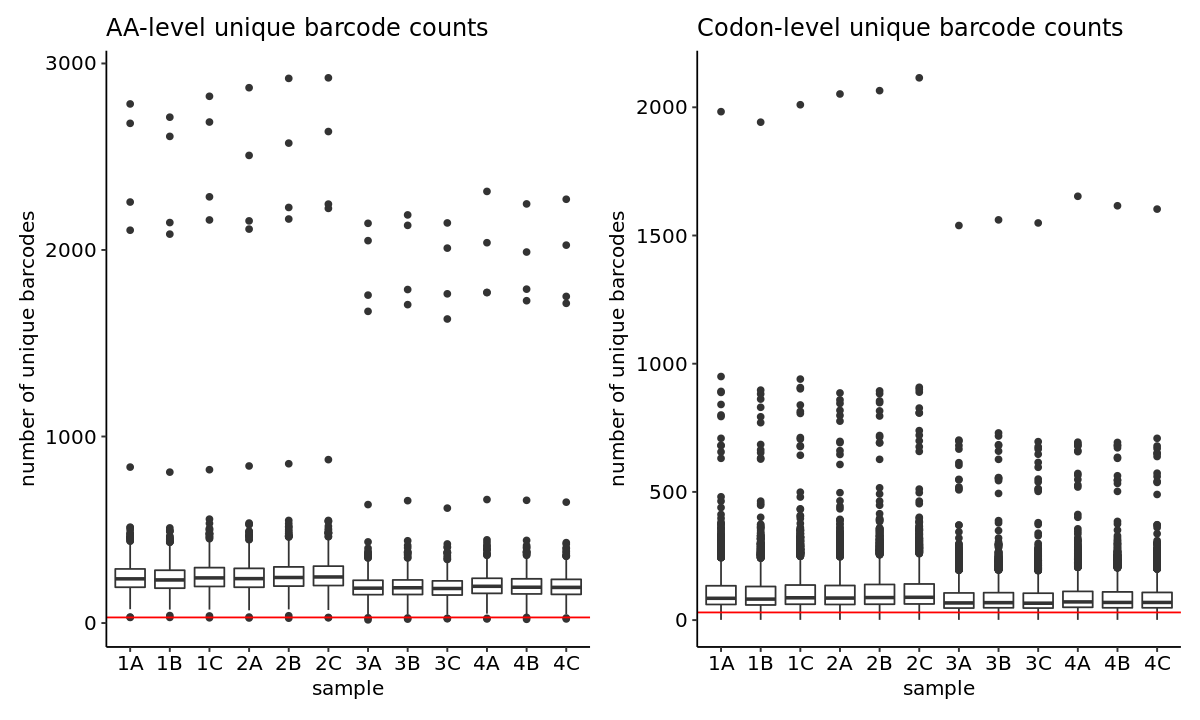

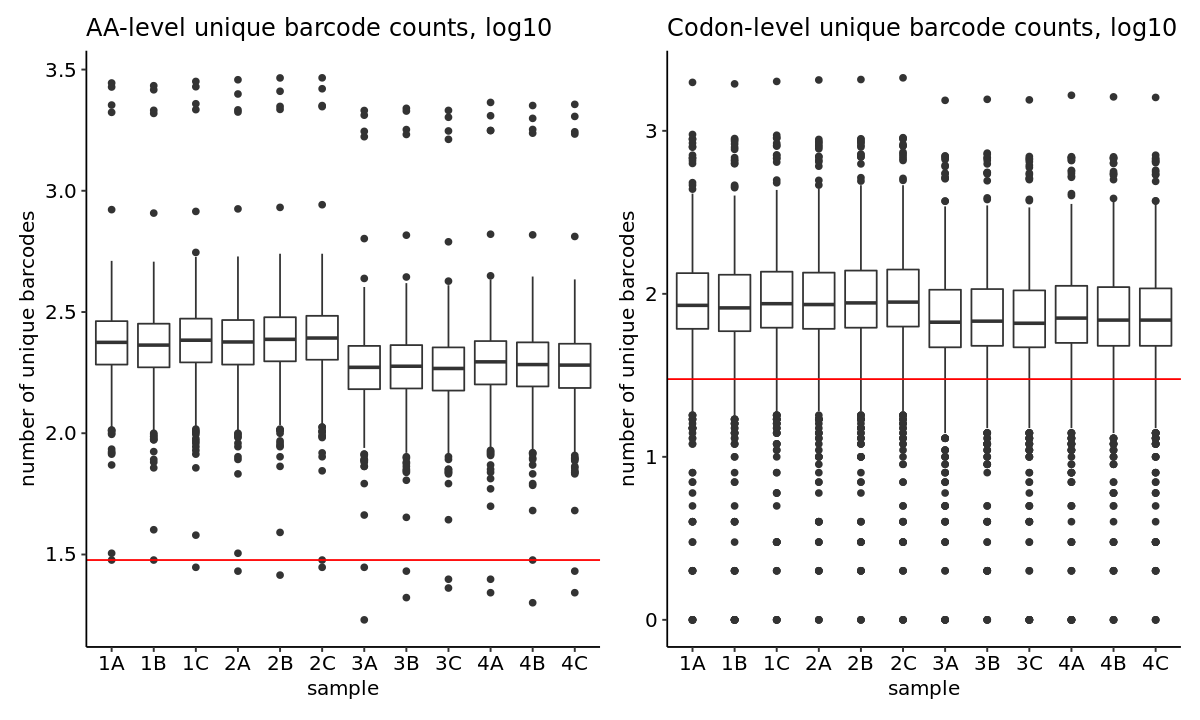

In [72]:
options(repr.plot.width = 10, repr.plot.height = 6)
res_count + codon_count
res_count_log + codon_count_log 

Each of the above points is a particular codon variant or residue variant, and the count is the number of unique barcodes for that variant. We can break out the clone 8 distributions more directly as densities for presentation:

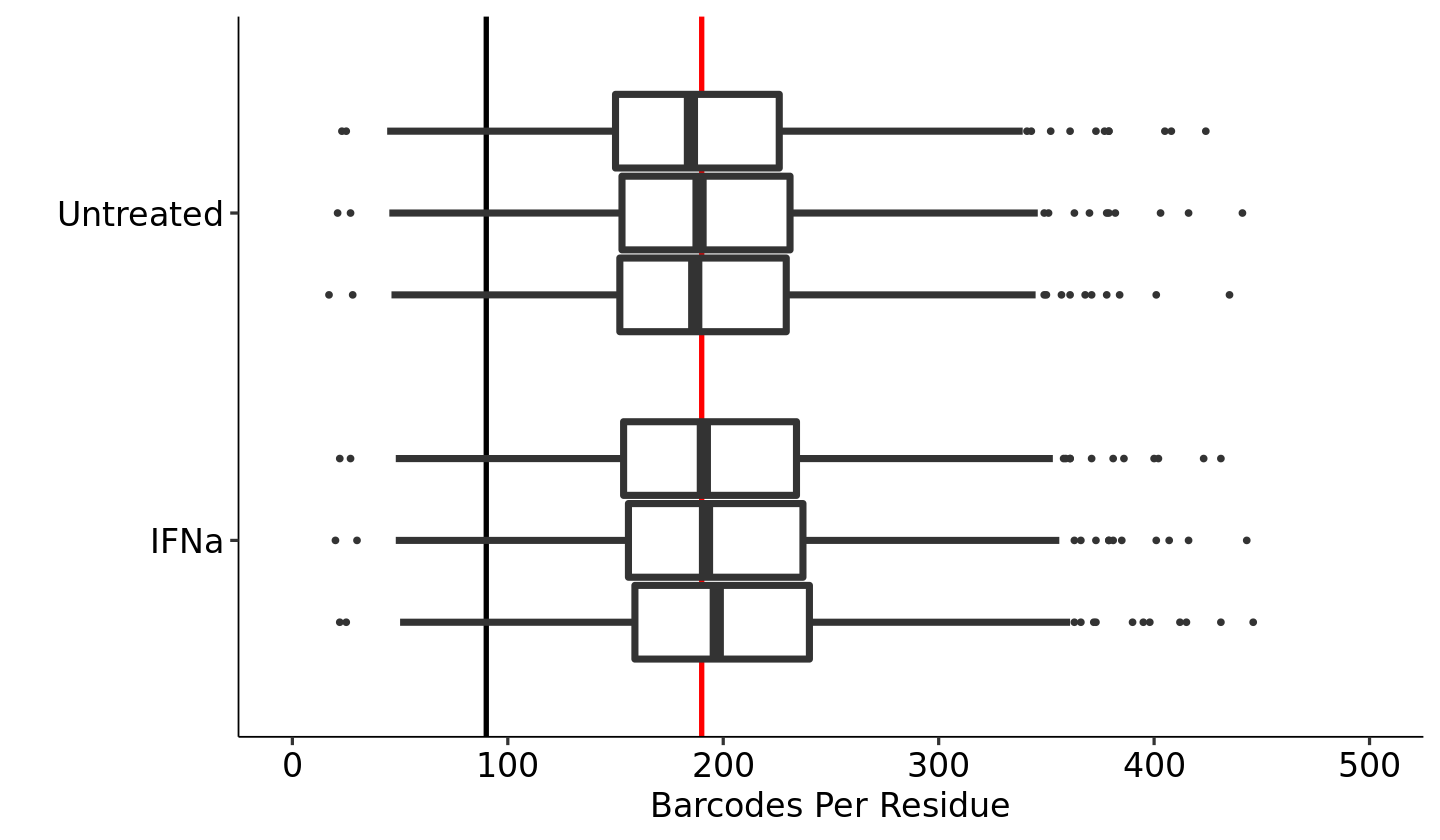

In [120]:
options(repr.plot.width = 12, repr.plot.height = 7)

glob_med <- bc_counts_aa %>% filter(grepl("3|4", sample))
glob_med <- median(glob_med$n)

bc_counts_aa %>%
    filter(grepl("3|4", sample)) %>%
    mutate(group = str_sub(sample, 1, 1),
           group = if_else(group == 3, "Untreated", "IFNa")) %>%
    ggplot() +
        geom_vline(xintercept = glob_med, size = 1.5, color = "red") +
        geom_vline(xintercept = 90, size = 1.5) +
        geom_boxplot(aes(x = n, group = sample, y = group), size = 2) +
        theme_pubr(base_size = 20) +
        coord_cartesian(xlim = c(0,500)) +
        xlab("Barcodes Per Residue") + ylab("") 
        

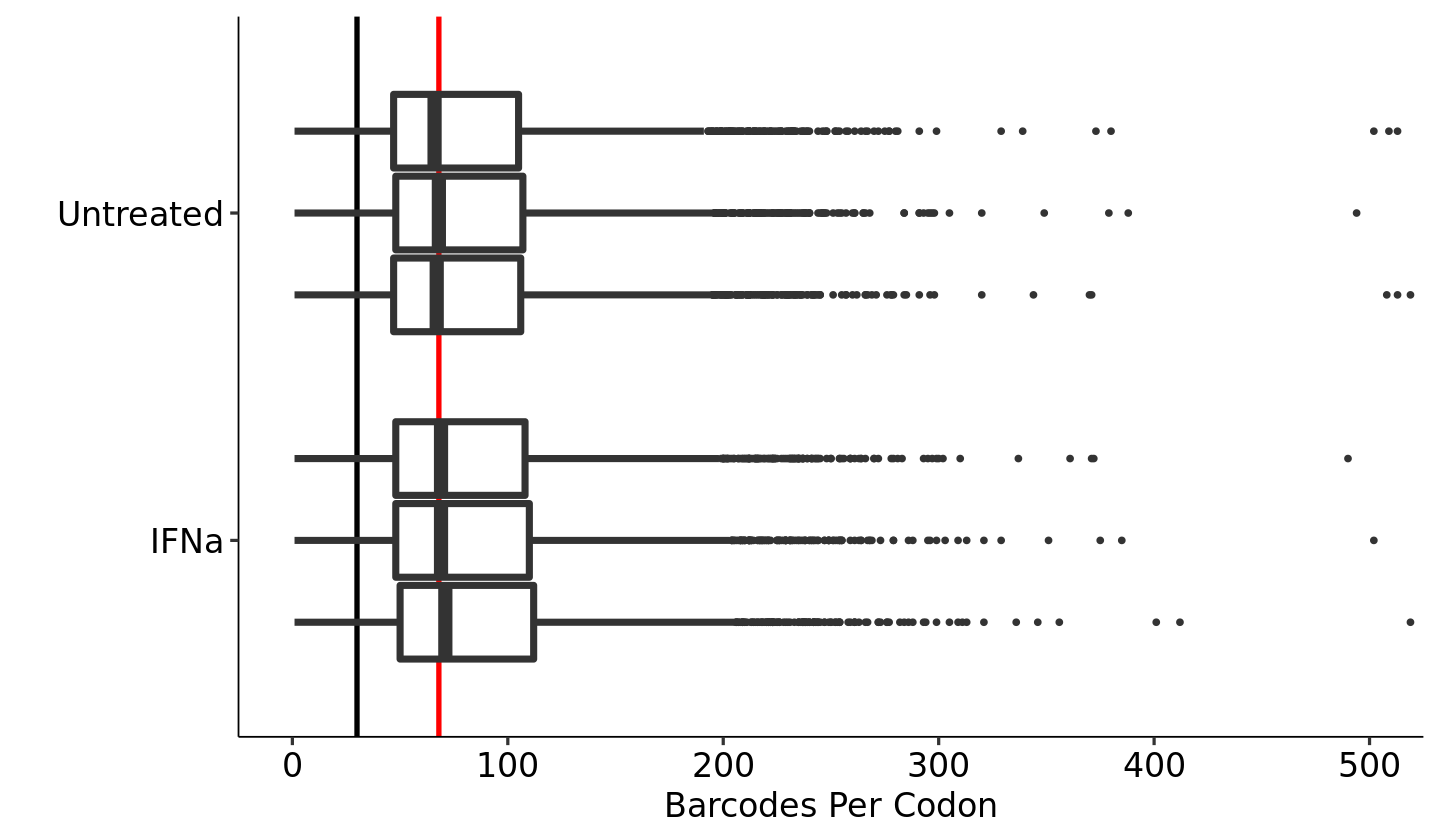

In [118]:
options(repr.plot.width = 12, repr.plot.height = 7)

glob_med <- bc_counts_codon %>% filter(grepl("3|4", sample))
glob_med <- median(glob_med$n)

bc_counts_codon %>%
    filter(grepl("3|4", sample)) %>%
    mutate(group = str_sub(sample, 1, 1),
           group = if_else(group == 3, "Untreated", "IFNa")) %>%
    ggplot() +
        geom_vline(xintercept = glob_med, size = 1.5, color = "red") +
        geom_vline(xintercept = 30, size = 1.5) +
        geom_boxplot(aes(x = n, group = sample, y = group), size = 2) +
        theme_pubr(base_size = 20) +
        coord_cartesian(xlim = c(0,500)) +
        xlab("Barcodes Per Codon") + ylab("") 
        

We can also plot the actual read counts of each barcode across samples. This shows an expected spike at zero for barcodes with exactly one read count:

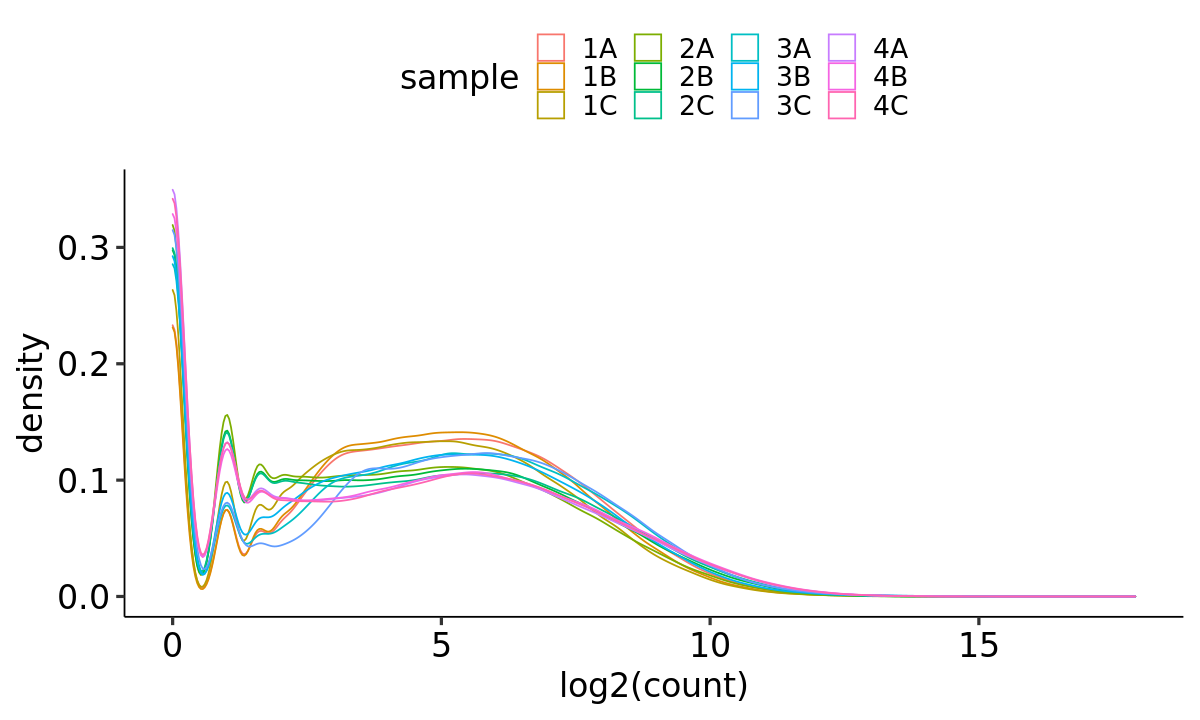

In [35]:
options(repr.plot.width = 10, repr.plot.height = 6)
ggplot(mapped_counts) +
    geom_density(aes(x = log2(count), color = sample)) +
    theme_pubr(base_size = 20)

Note that while these barcodes have only one read count in a given sample in the 1x26 dataset, the fact that it is in the barcode map means it was detected in at least two sequencing replicates with at least three reads each in the barcode mapping data. Nonetheless, we can verify that we still would have enough barcode coverage even if we removed "lowly expressed" barcodes - again, we will not do this for the actual analysis, but we can just check:

In [36]:
bc_counts_aa <- mapped_counts %>%
    filter(mut_aa != "WT" & count >= 4) %>%
    group_by(sample,wt_aa,mut_aa,pos) %>%
    count()

bc_counts_codon <- mapped_counts %>%
    filter(mut_aa != "WT" & count >= 4) %>%
    group_by(sample,wt_codon,mut_codon,pos) %>%
    count()

res_count <- bc_counts_aa %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = n)) +
        theme_pubr() +
        geom_hline(yintercept = 30, color = "red") +
        ylab("number of unique barcodes") + ggtitle("AA-level unique barcode counts, \nread count >= 4")

codon_count <- bc_counts_codon %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = n)) +
        theme_pubr() +
        geom_hline(yintercept = 30, color = "red")  +
        ylab("number of unique barcodes") + ggtitle("Codon-level unique barcode counts, \nread count >= 4")

res_count_log <- bc_counts_aa %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = log10(n))) +
        theme_pubr() +
        geom_hline(yintercept = log10(30), color = "red") +
        ylab("number of unique barcodes") + ggtitle("AA-level unique barcode counts, log10, \nread count >= 4")

codon_count_log <- bc_counts_codon %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = log10(n))) +
        theme_pubr() +
        geom_hline(yintercept = log10(30), color = "red")  +
        ylab("number of unique barcodes") + ggtitle("Codon-level unique barcode counts, log10, \nread count >= 4")

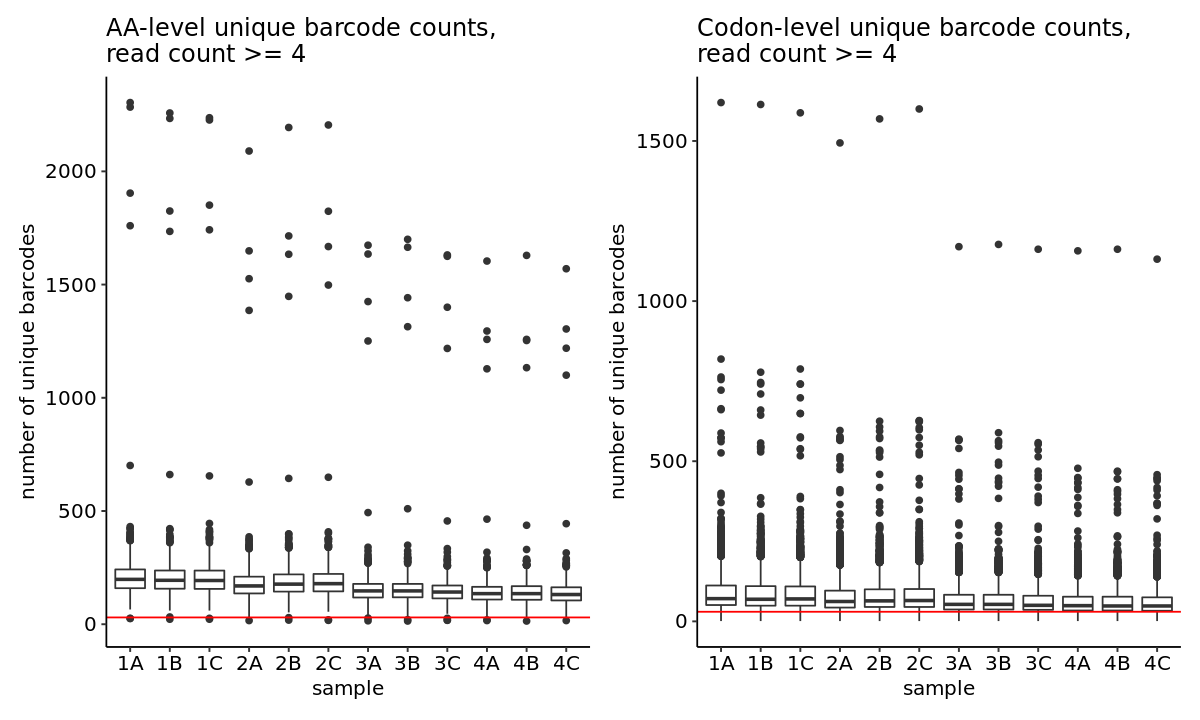

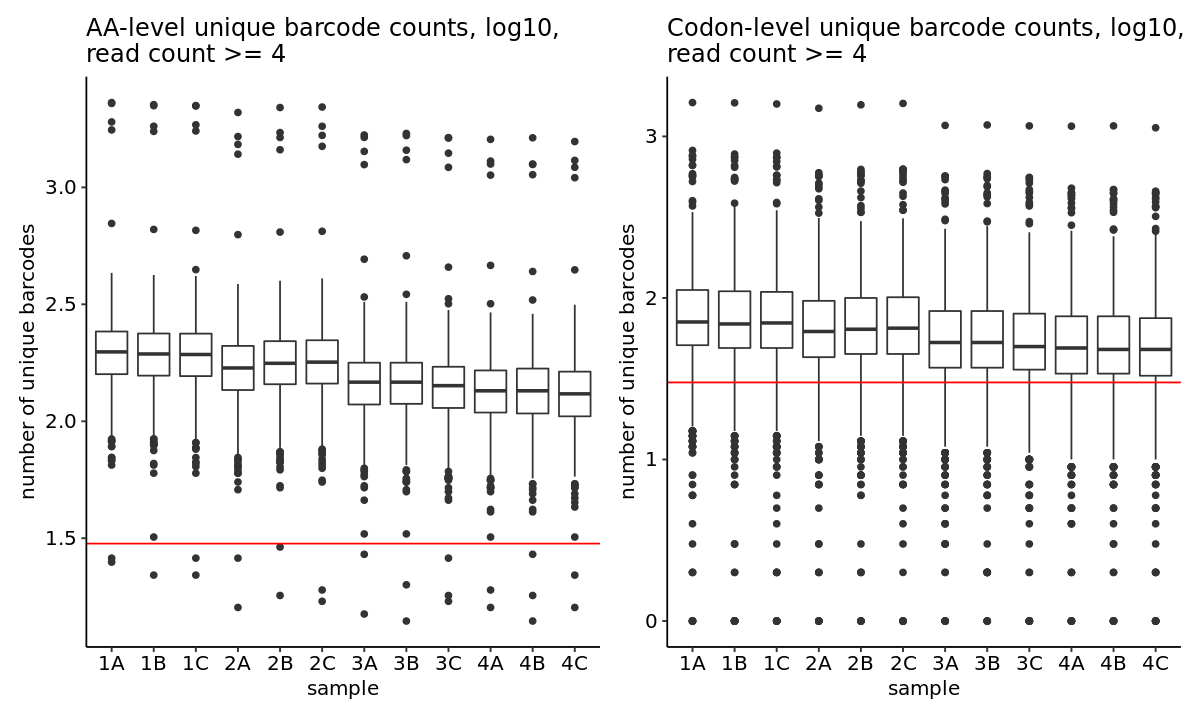

In [37]:
options(repr.plot.width = 10, repr.plot.height = 6)
res_count + codon_count
res_count_log + codon_count_log 

We still observe a median of >30 barcodes per codon level variant, even requiring that a barcode have at least four reads to be included for a given sample. We do not need to apply this filter given how our regression model works, but even if we did our depth would still be quite good.

We can also assess coverage by plotting the numbers of barcodes per variant across each amino acid or codon and position. Since the samples are fairly similar

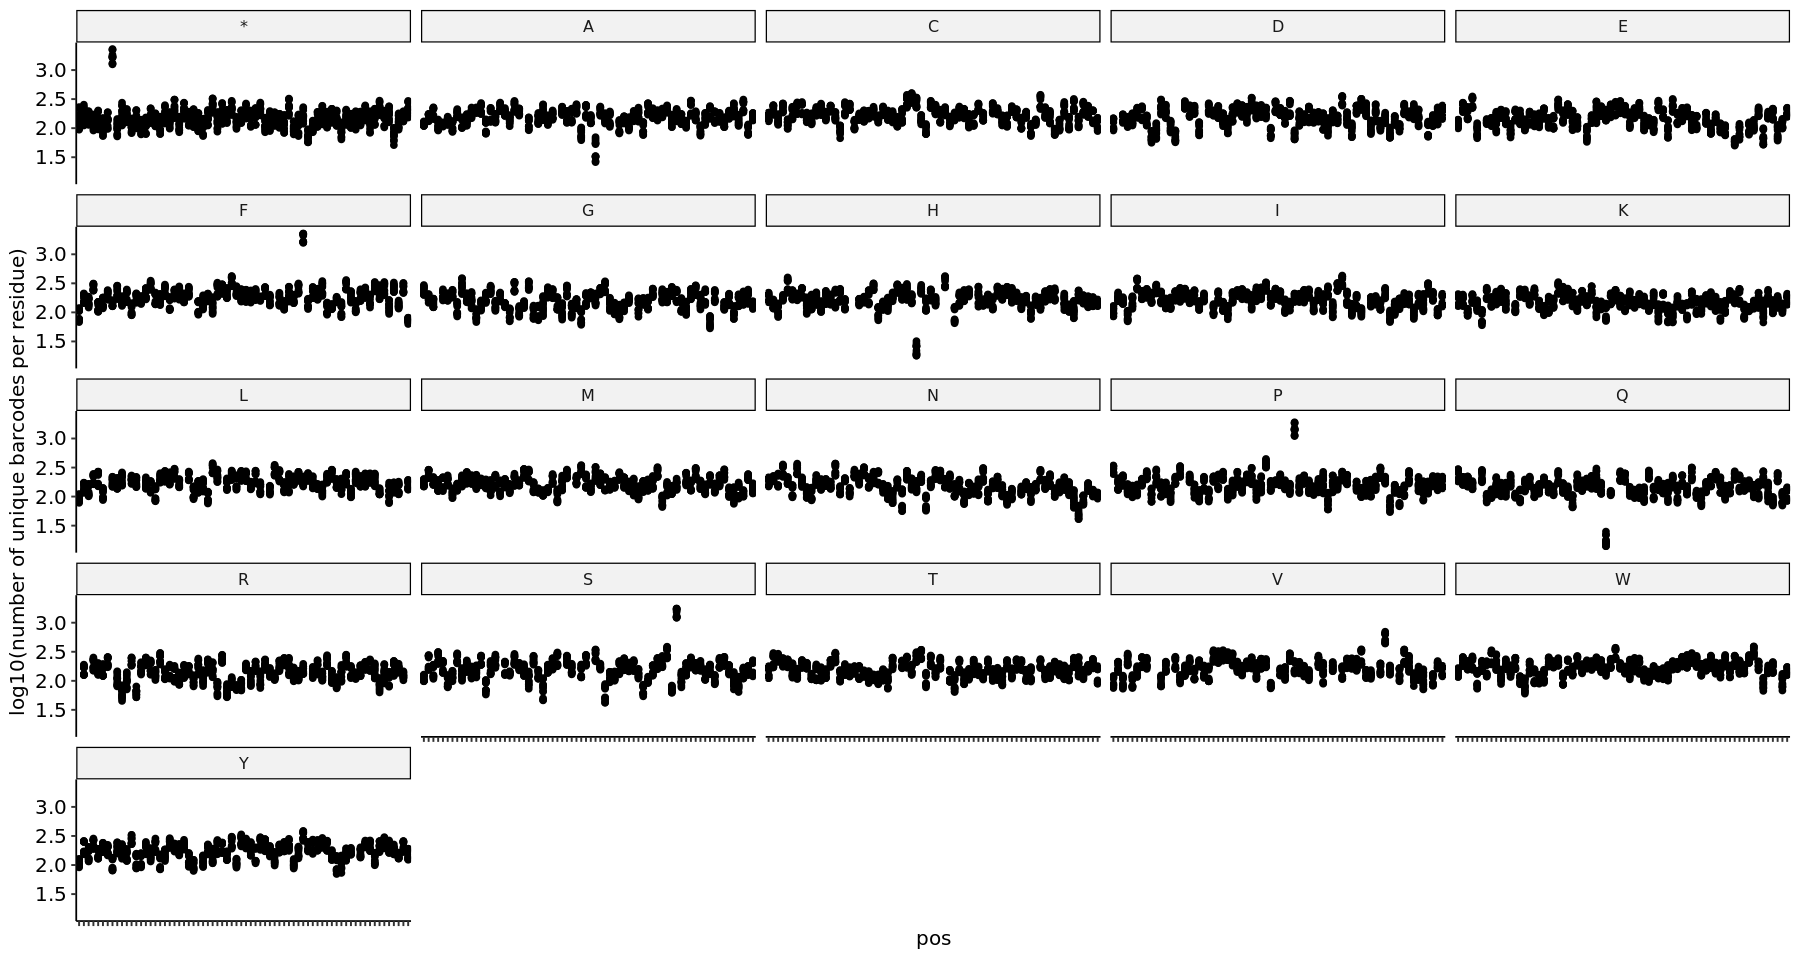

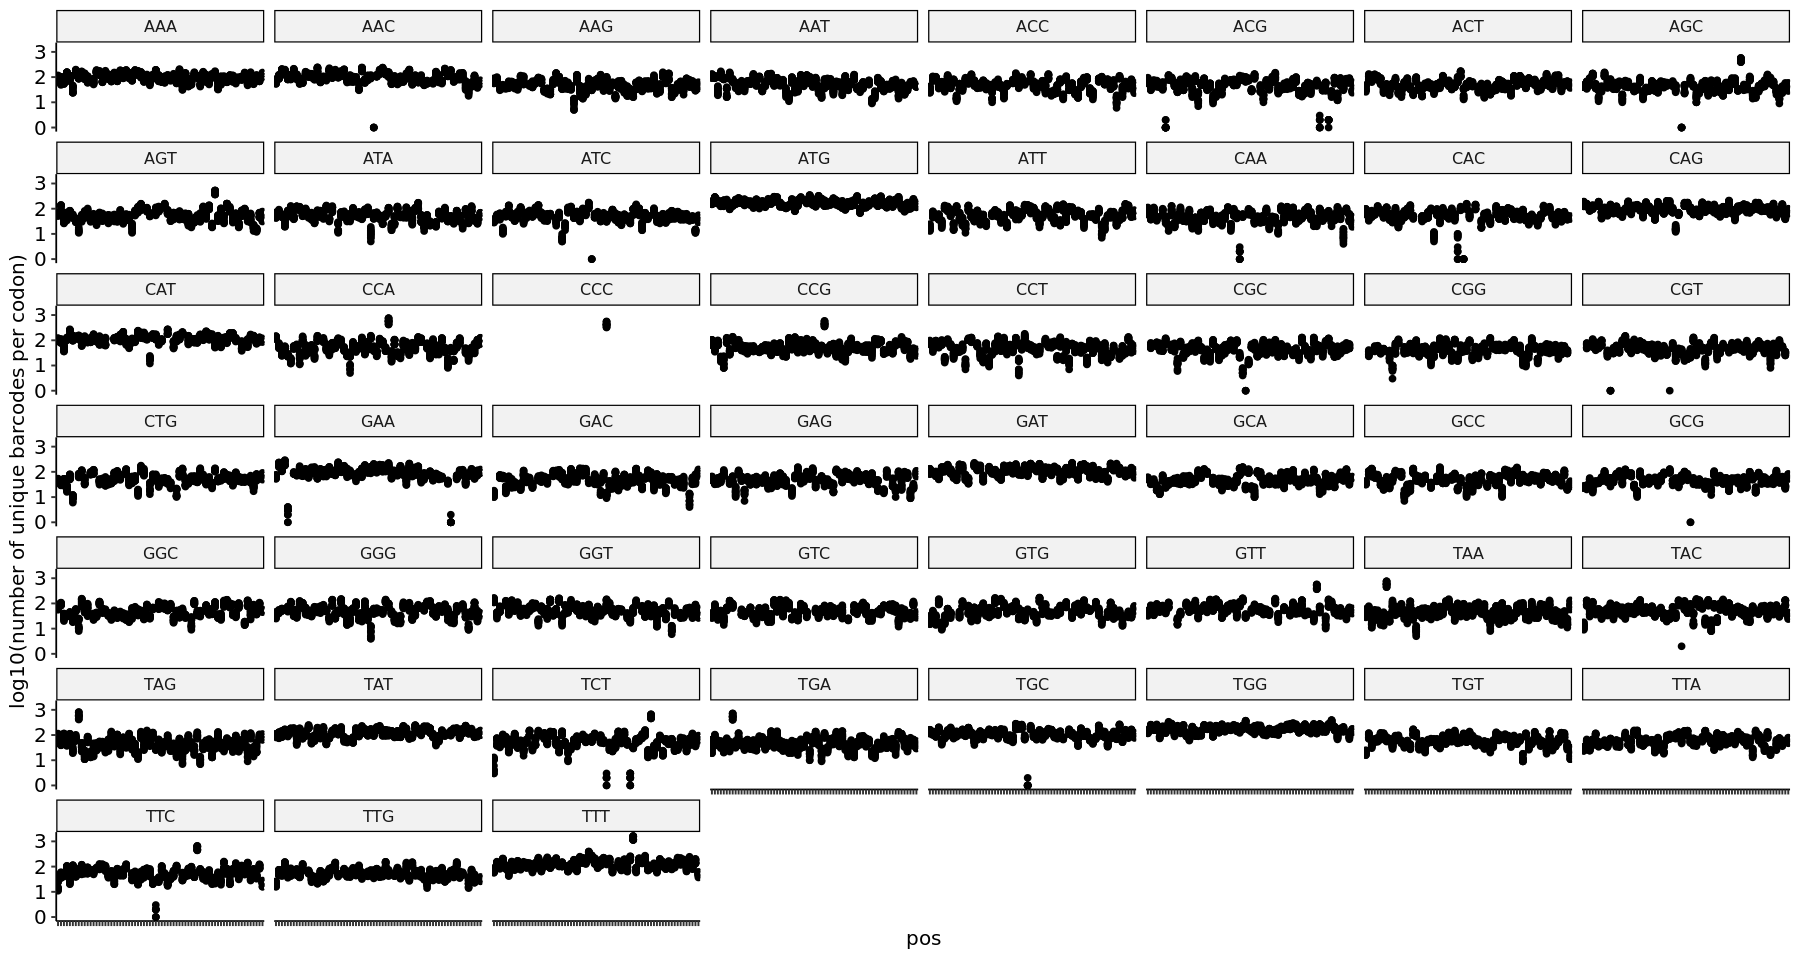

In [38]:
options(repr.plot.width = 15, repr.plot.height = 8)
ggplot(bc_counts_aa) +
    geom_point(aes(x = pos, y = log10(n))) +
    facet_wrap(~mut_aa) +
    theme_pubr() +
    theme(axis.text.x = element_blank()) + ylab("log10(number of unique barcodes per residue)")

ggplot(bc_counts_codon) +
    geom_point(aes(x = pos, y = log10(n))) +
    facet_wrap(~mut_codon) +
    theme_pubr() +
    theme(axis.text.x = element_blank()) + ylab("log10(number of unique barcodes per codon)")

We can break out combined and polished versions of these plots for external presentation with just clone 8:

In [131]:
bc_counts_codon_c8 <- mapped_counts %>%
    filter(mut_aa != "WT", grepl("3|4", sample)) %>%
    group_by(sample,wt_aa,mut_aa,pos) %>%
    count()

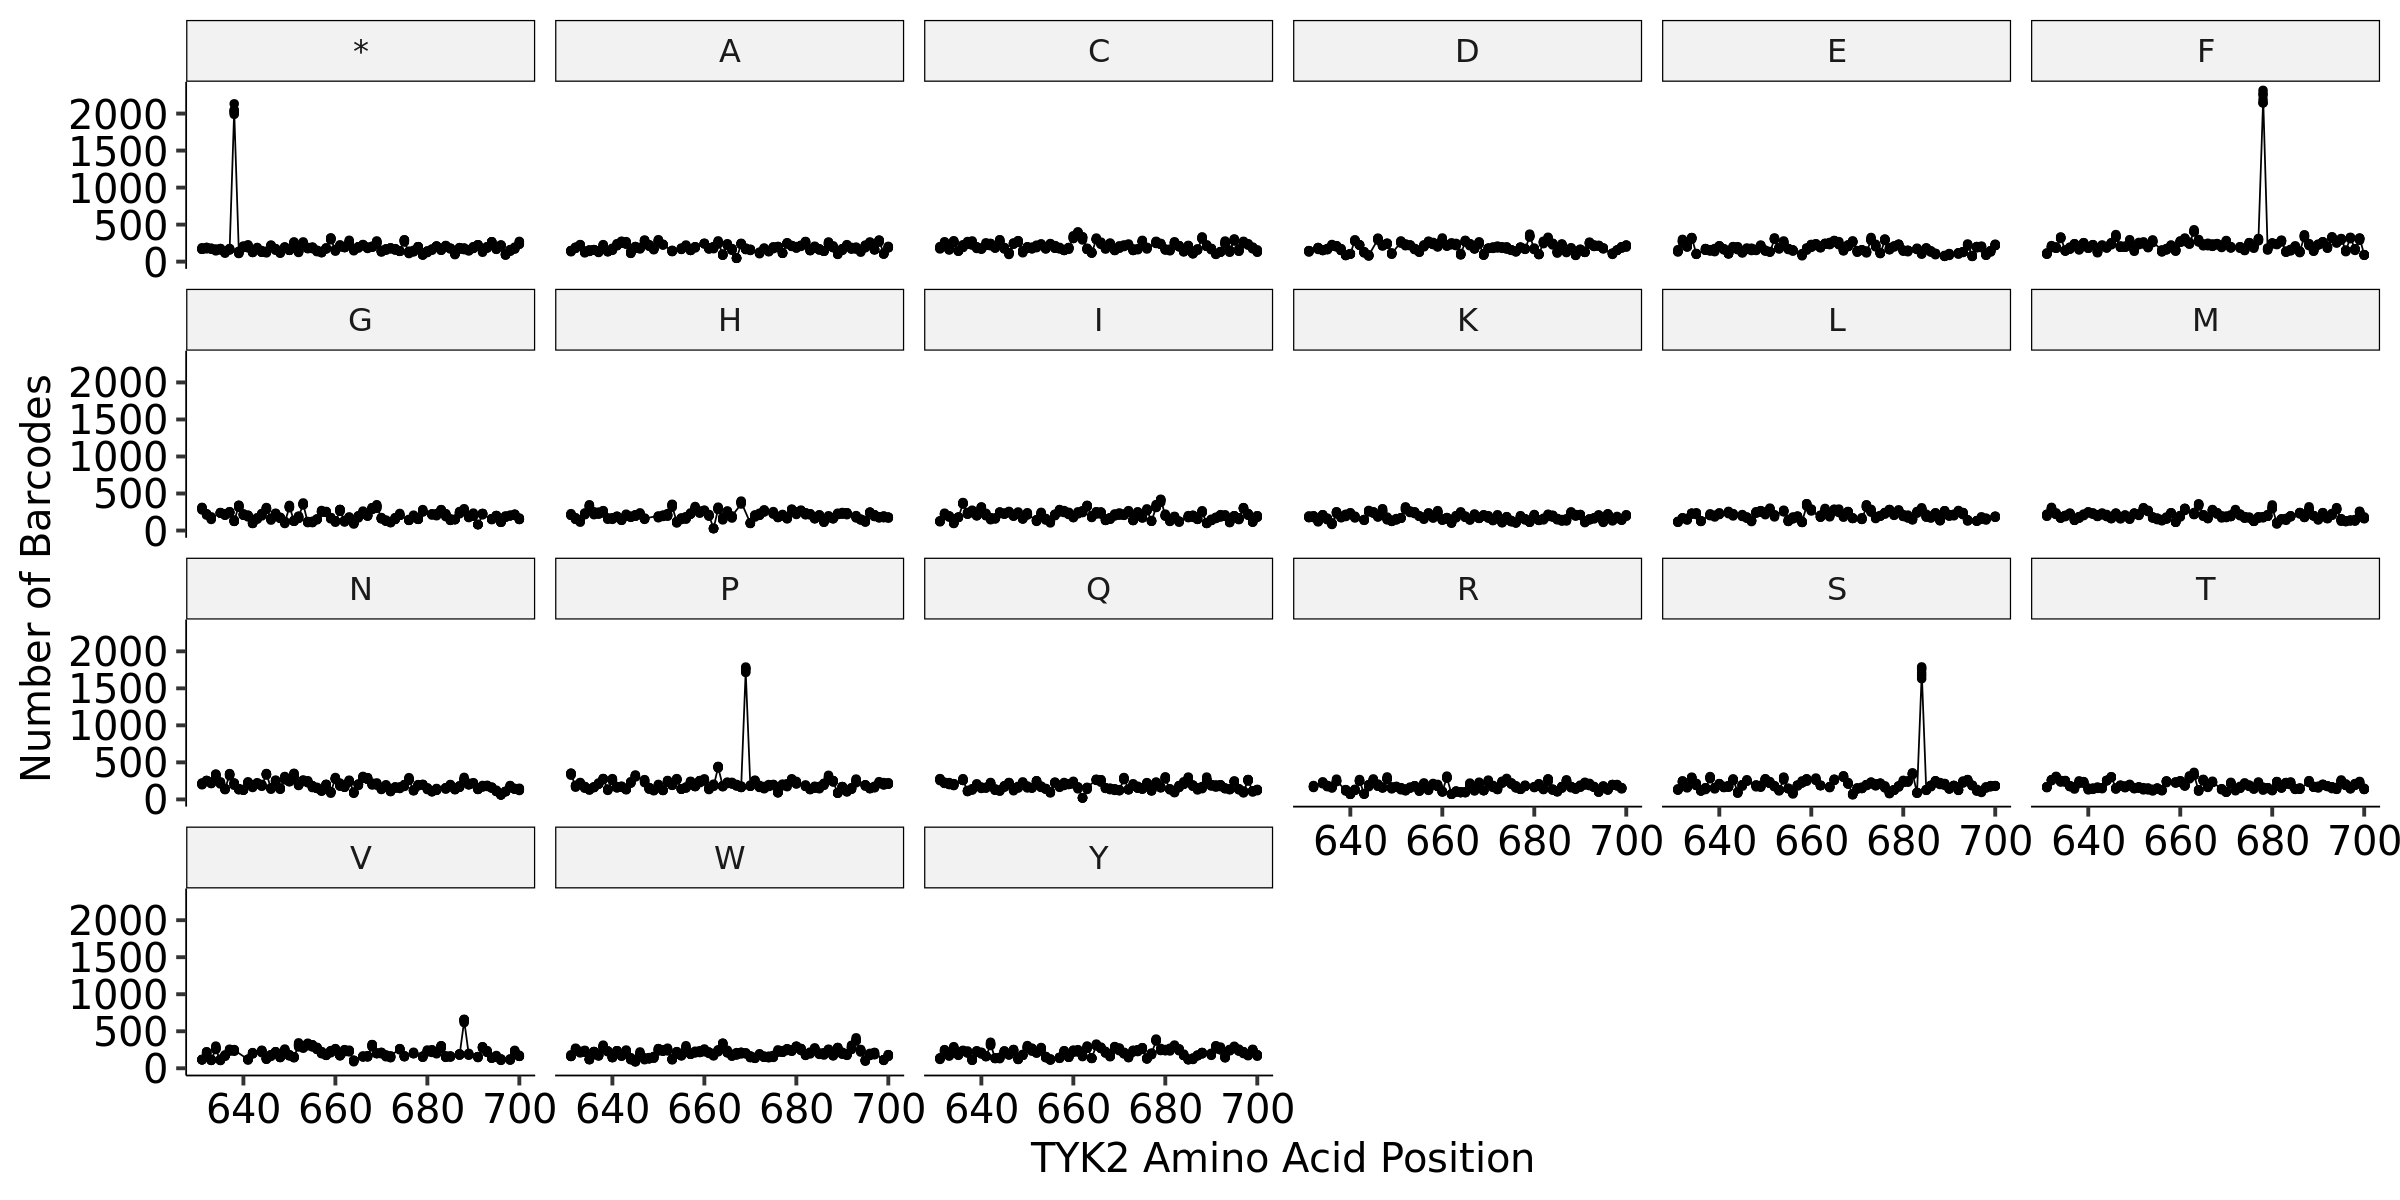

In [141]:
options(repr.plot.height = 10, repr.plot.width = 20)
bc_counts_codon_c8 %>%
    mutate(pos = as.numeric(pos)) %>%
    ggplot() +
            geom_point(aes(x = pos, y = n), size = 2) +
            geom_line(aes(x = pos, y = n)) +
            theme_pubr(base_size = 24) +
            facet_wrap(~mut_aa, nrow = 4) +
            xlab("TYK2 Amino Acid Position") + ylab("Number of Barcodes")

### Statistical Models <a name="part2"></a>

We use a hierarchical negative binomial mixed model to quantify mutation vs wild-type (WT) effects, and to test whether they are different from zero or across conditions. We apply two slight variations on the same underlying model: one that shares barcode information across condition for the inference of _across condition_ effects, and another that limits barcode sharing to within condition for the inference of _within condition_ effects. The architecture of the underlying model is shown below, with the difference being how information is shared between the colored circles at the top:

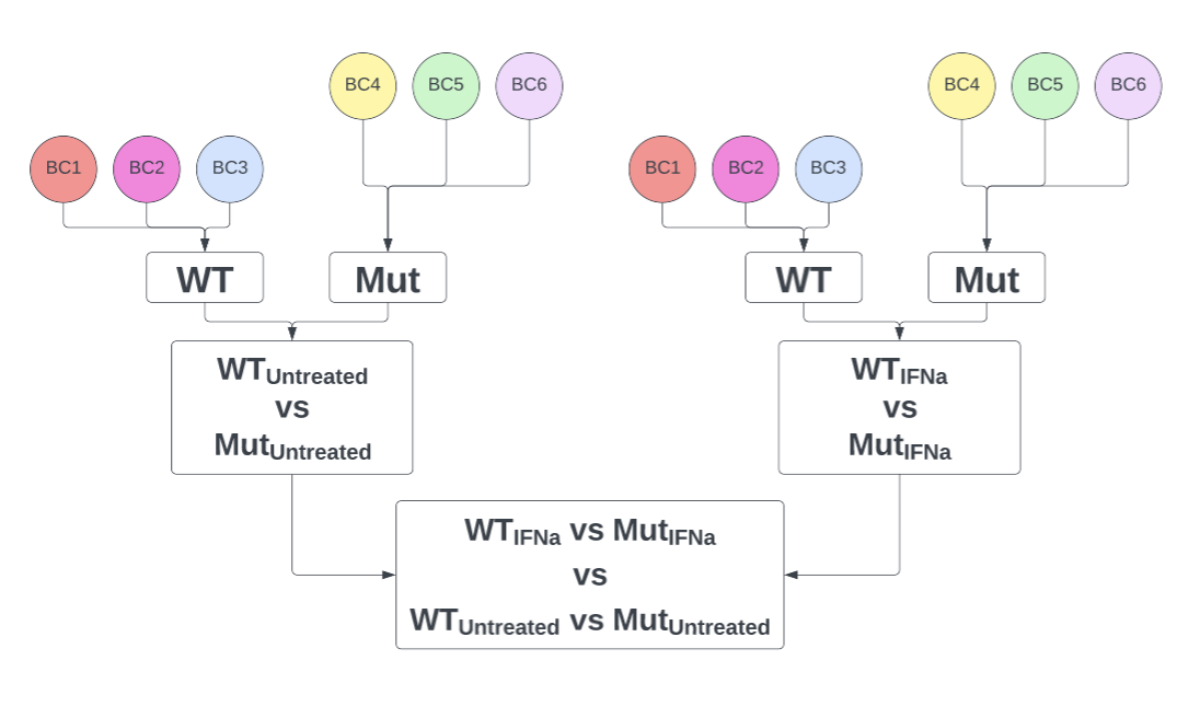

In [1]:
library(png)
options(repr.plot.width = 10, repr.plot.height = 6)
img <- readPNG("nbmm-hierarch.png")
grid::grid.raster(img)

In the separated model, we share information within each condition only. In the schematic below, the dashed lines mark the boundaries of information sharing:

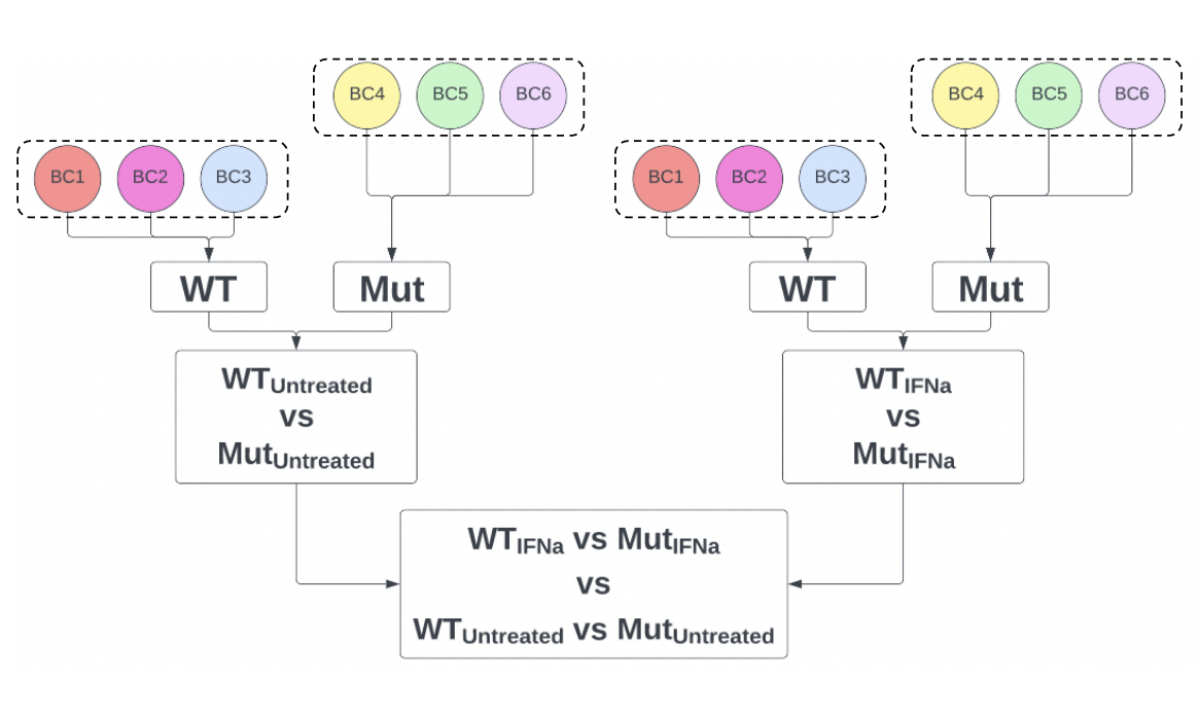

In [2]:
img <- readPNG("nbmm-hierarch-1.png")
grid::grid.raster(img)

In contrast, the separated model pools information across both conditions to maximise power for detecting within-barcode changes across condition:

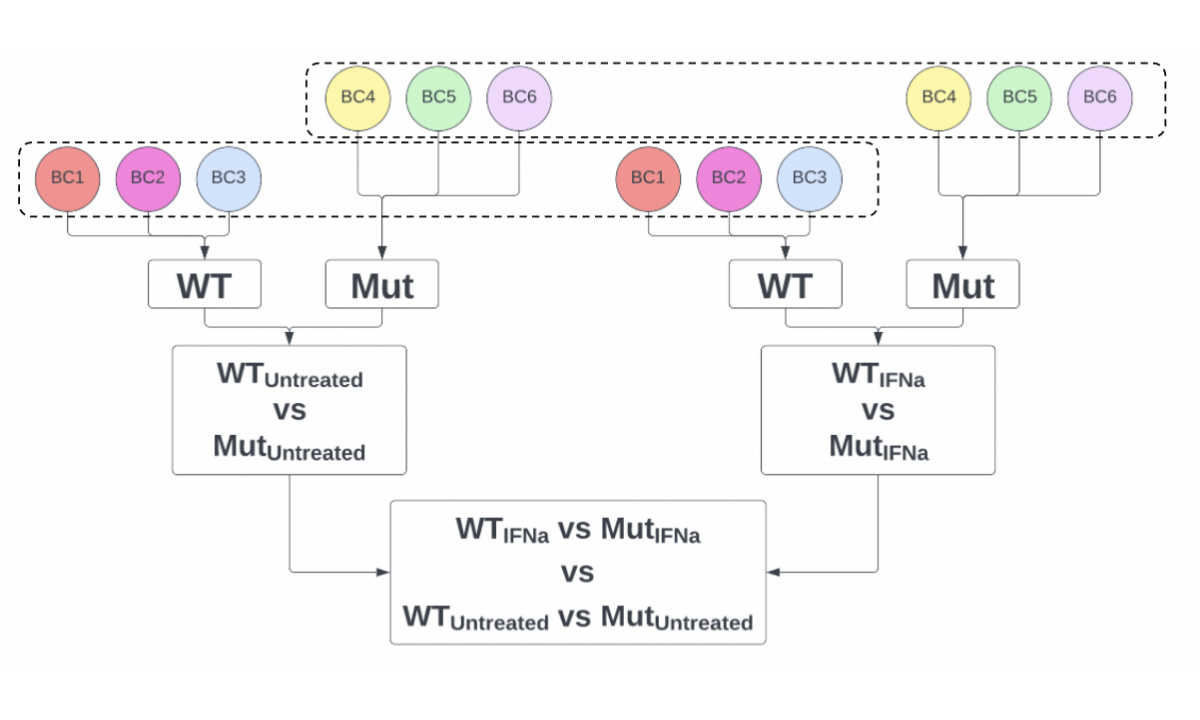

In [3]:
img <- readPNG("nbmm-hierarch-2.png")
grid::grid.raster(img)

We obtain three sets of summary statistics: the WT vs Mutant effects in each of Untreated and IFNa separately, as well as the difference between those two effects. We share barcode information between conditions only when the test is for a difference between conditions. Applying a Benjamini-Hochberg correction and a 1% FDR threshold, we obtain the following counts of significant mutations in each comparison:

In [3]:
coefs_long_comb <- read_tsv("../sumstats/10-combined.sumstats.tsv") %>%
    mutate(term = gsub("condition|mut_aa","",term)) %>%
    separate(term, c("condition","aa"), sep = ":")

coefs_contr_comb <- coefs_long_comb %>%
    select(-statistic, -p.value) %>%
    group_by(pos, clone, chunk, aa) %>%
    pivot_wider(names_from = condition, values_from = c(estimate, std.error)) %>%
    summarize(estimate = estimate_IFNa2a - estimate_none,
              std.error = sqrt((std.error_IFNa2a^2)+(std.error_none^2)),
              statistic = estimate/std.error,
              p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                             (1-pnorm(statistic, sd = 1))*2)) %>%
    select(pos,clone,chunk,aa,estimate,std.error,statistic,p.value)

Rows: 5600 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): clone, term
dbl (6): pos, chunk, estimate, std.error, statistic, p.value

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'pos', 'clone', 'chunk'. You can override
using the `.groups` argument.


In [4]:
coefs_long_sep <- read_tsv("../sumstats/10-separated.sumstats.tsv") %>%
    mutate(aa = gsub("mut_aa","",term)) %>% select(-term) %>%
    rename("condition" = "cyto")

coefs_wt_sep <- coefs_long_sep %>% 
    filter(aa == "WT") %>% 
    select(pos,clone,condition,
           norm_estimate = estimate, norm_err = std.error)

coefs_contr_sep <- coefs_long_sep %>% 
    inner_join(coefs_wt_sep) %>% 
    filter(aa != "WT") %>%
    group_by(pos, clone, condition, chunk, aa) %>%
    summarize(estimate = estimate - norm_estimate,
              std.error = sqrt((std.error^2)+(norm_err^2)),
              statistic = estimate/std.error,
              p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                             (1-pnorm(statistic, sd = 1))*2)) %>%
    select(pos,condition,clone,chunk,aa,estimate,std.error,statistic,p.value)

coefs_contr_sep_final <- coefs_contr_sep %>%
    select(-statistic, -p.value) %>%
    group_by(pos, clone, chunk, aa) %>%
    pivot_wider(names_from = condition, values_from = c(estimate, std.error)) %>%
    summarize(estimate = estimate_IFNa2a - estimate_none,
              std.error = sqrt((std.error_IFNa2a^2)+(std.error_none^2)),
              statistic = estimate/std.error,
              p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                             (1-pnorm(statistic, sd = 1))*2)) %>%
    select(pos,clone,chunk,aa,estimate,std.error,statistic,p.value)

Rows: 5880 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): clone, cyto, term
dbl (6): pos, chunk, estimate, std.error, statistic, p.value

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining, by = c("pos", "clone", "condition")
`summarise()` has grouped output by 'pos', 'clone', 'condition', 'chunk'. You
can override using the `.groups` argument.
`summarise()` has grouped output by 'pos', 'clone', 'chunk'. You can override
using the `.groups` argument.


In [31]:
coefs_contr_comb %>%
    mutate(condition = "IFNa2a - Untreated") %>%
    bind_rows(coefs_contr_sep) %>%
    mutate(condition = relevel(factor(condition), ref = "none")) %>%
    group_by(condition, clone) %>%
    mutate(fdr = p.adjust(p.value, method = "BH"),
           signif = if_else(fdr < 0.01, "significant", "not significant")) %>%
    group_by(condition, clone, signif) %>%
    count() %>%
    pivot_wider(names_from = signif, values_from = n, values_fill = 0) %>%
    rename(comparison = condition) %>%
    ungroup() %>%
    mutate(model = c(rep("separate",4),rep("combined",2))) %>%
    relocate(comparison, model, clone) %>%
    kable() 



|comparison         |model    |clone | not significant| significant|
|:------------------|:--------|:-----|---------------:|-----------:|
|none               |separate |c1    |            1400|           0|
|none               |separate |c8    |            1400|           0|
|IFNa2a             |separate |c1    |            1110|         290|
|IFNa2a             |separate |c8    |            1196|         204|
|IFNa2a - Untreated |combined |c1    |            1090|         310|
|IFNa2a - Untreated |combined |c8    |            1149|         251|

When Untreated, we observe no significant effects at a 1% FDR in either clone, while when treated with IFNa we observe either 290 or 204 mutations with significantly different activity from wild-type without sharing barcode information. If we allow the sharing of barcode information and test for a difference between conditions, the number of significant mutations increases to 310 and 251 in each clone, reflecting the expected increase in power. However, note that while more powerful this is technically a different comparison (e.g. evaluating whether two Mut vs WT effects are different from each other, rather than whether one Mut vs WT effect is different from zero).

A natural next question is whether the same or different variants are being detected between clones and comparisons, which we can visualize via an upset plot:

In [33]:
upset_data <- coefs_contr_comb %>%
    mutate(condition = "IFNa2a - Untreated") %>%
    bind_rows(coefs_contr_sep) %>%
    mutate(condition = relevel(factor(condition), ref = "none")) %>%
    group_by(condition, clone) %>%
    mutate(fdr = p.adjust(p.value, method = "BH"),
           mut = paste0(pos, "_", clone, "_", aa),
           condition) %>%
    filter(fdr <= 0.01) %>%
    ungroup() %>%
    select(mut, condition) %>%
    group_by(condition) %>%
    summarize(mut = list(as.character(mut)))
upset_data <- list("IFNa" = upset_data$mut[[1]], "IFNa - Untreated" = upset_data$mut[[2]], "Untreated" = list())

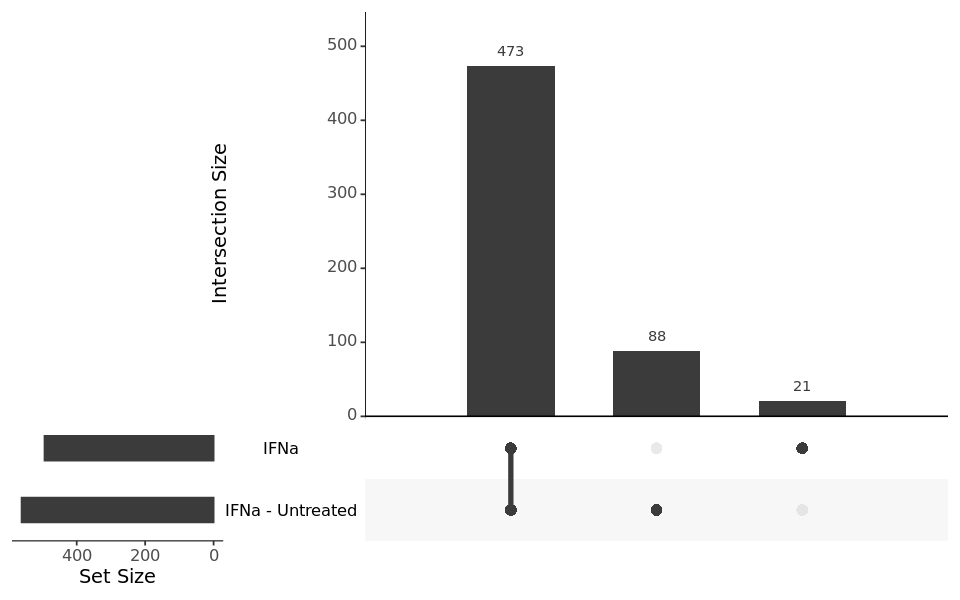

In [34]:
options(repr.plot.width = 8, repr.plot.height = 5)
upset(fromList(upset_data), order.by = "freq", text = 1.4, point.size = 3, line.size = 1.5)

The large majority of mutations with a signiicant effect are significant in both IFNa considered alone, as well when testing the difference in effect from Untreated. However, a subset of mutations become significant only in the "IFNa - Untreated" comparison due to increased power, and a very small number become non-significant. In this last case, these are variants which display a similar significant difference from wild-type in both Untreated and IFNa.

To see the concrete improvement in power that comes with barcode information sharing, we can compare the `IFNa - Untreated` comparison above to the same comparison, but instead calculate it by subtracting the separately-estimated `IFNa` and `Untreated` values of using the combined model.

Below, we show the Z-statistic of the final (Mut vs WT) vs (Mut vs WT) comparison with either information sharing (x-axis) or no sharing (y-axis), and colored by stop codon. Generally, the observed loss-of-function variants including stops are much more significant (i.e. much more negative) in both clones when combining barcode information rather than keeping it separate.

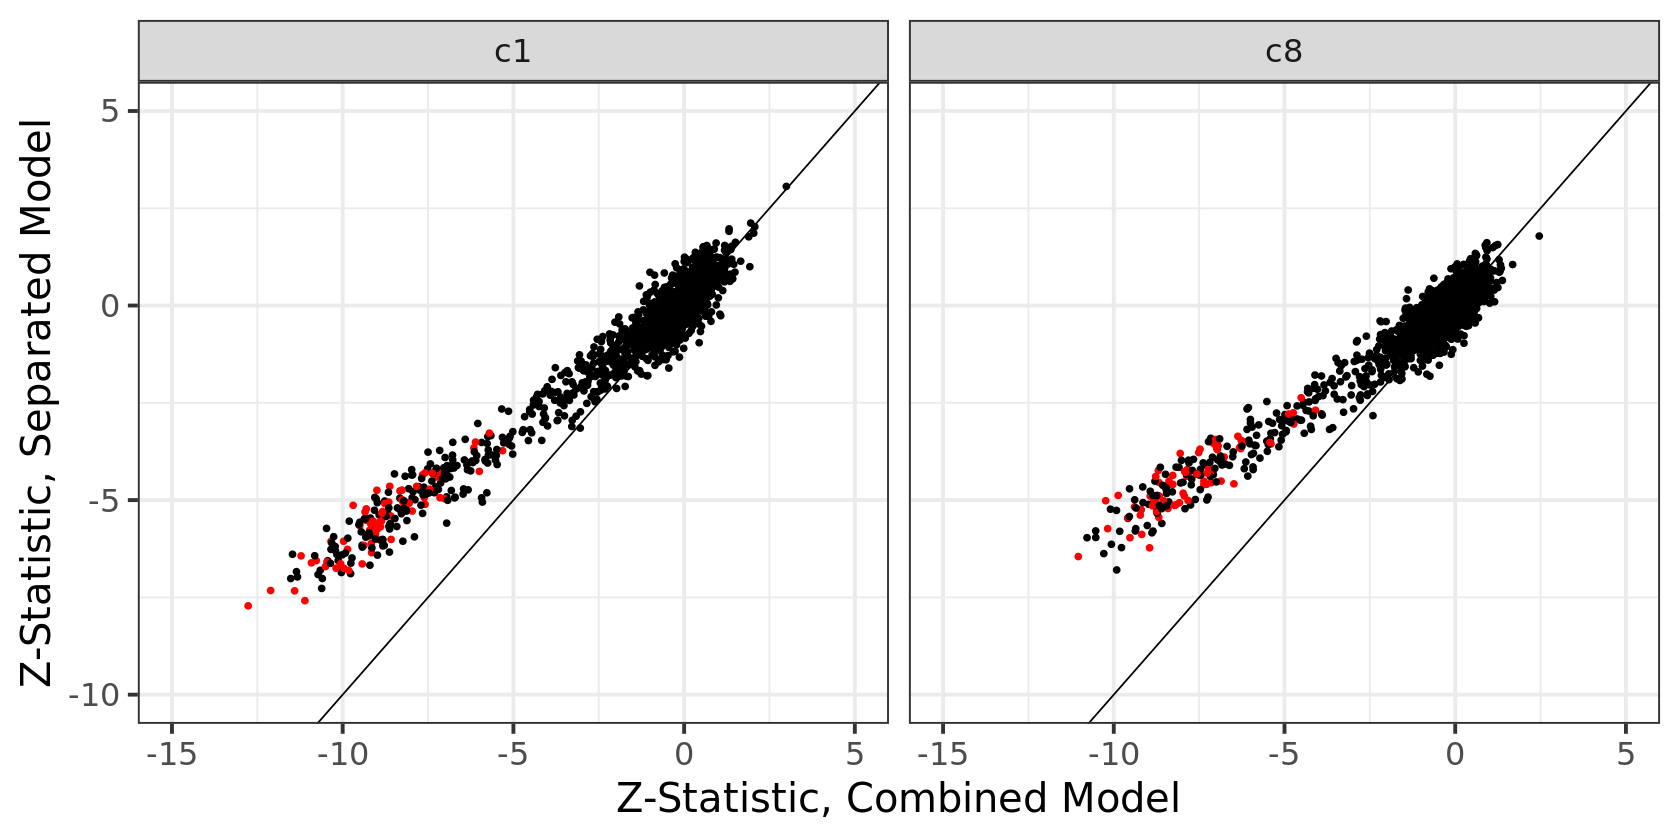

In [35]:
coef_compare_secondary <- inner_join(coefs_contr_sep_final, coefs_contr_comb, by = c("pos","clone","chunk","aa"))

options(repr.plot.width = 14, repr.plot.height = 7, warn = -1)
ggplot(coef_compare_secondary) +
    geom_point(aes(x = statistic.y, y = statistic.x, color = if_else(aa == "*", "red","black"))) +
    theme_bw(base_size = 24) +
    facet_wrap(~clone) +
    geom_abline(slope = 1, intercept = 0) +
    xlab("Z-Statistic, Combined Model") + ylab("Z-Statistic, Separated Model") +
    scale_color_identity() +
    xlim(c(-15,5)) + ylim(c(-10,5))

### Visualization and Interpretation <a name="part3"></a>

A simple way to visualize summary statistics across a large variant set is with volcano plots, which show the log fold change on the x-axis and the -log10 p-value on the y-axis. Here, stop codons are still colored red:

Warning message:
“Removed 8 rows containing missing values (geom_point).”


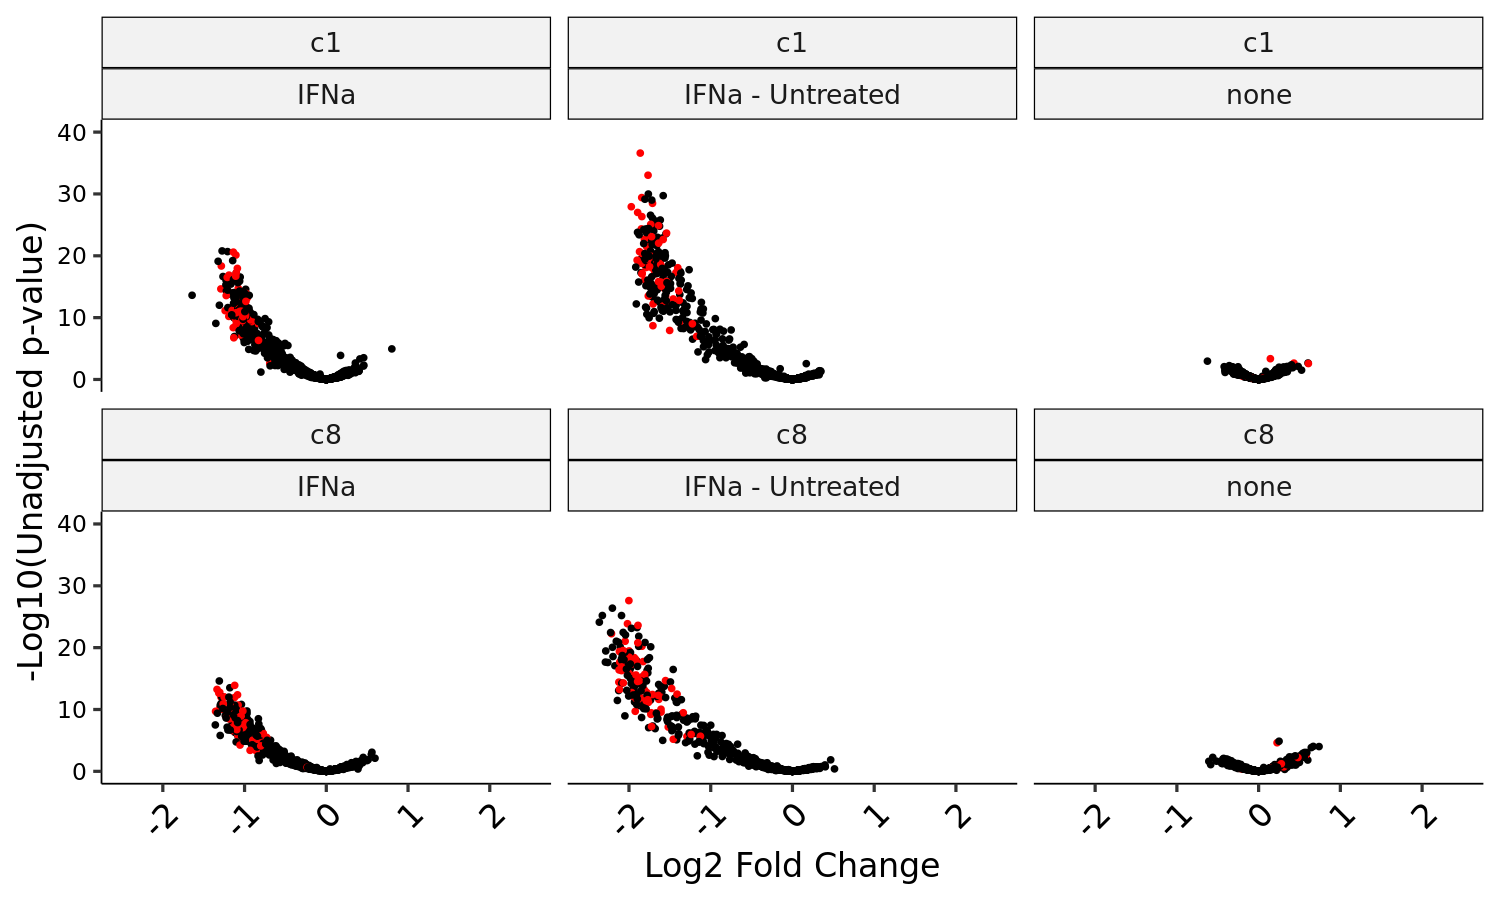

In [6]:
sumstats <- coefs_contr_comb %>%
    mutate(condition = "IFNa2a - Untreated") %>%
    bind_rows(coefs_contr_sep) %>%
    mutate(condition = relevel(factor(condition), ref = "none"),
           condition = gsub("IFNa2a", "IFNa", condition)) %>%
    group_by(condition, clone) %>%
    mutate(fdr = p.adjust(p.value, method = "BH"),
           signif = if_else(fdr < 0.01, "significant", "not significant")) 

options(repr.plot.height = 7.5, repr.plot.width = 12.5)
ggplot(sumstats %>% 
           mutate(aa = if_else(aa == "*", "Stop", aa))) +
        geom_point(aes(x = estimate/log(2), y = -log10(p.value),
                       color = if_else(aa == "Stop", "red", "black"))) +
        theme_pubr(base_size = 20, x.text.angle = 45) +
        theme(legend.text=element_text(size=20),
              legend.key.size = unit(1,"cm"),
              axis.text.y = element_text(size = 14)) +
        facet_wrap(~clone + condition, ncol = 3) +
        ylab("") + xlab("Log2 Fold Change") + ylab("-Log10(Unadjusted p-value)") +
        xlim(c(-2.5, 2.5)) + ylim(c(0,40)) +
        scale_color_identity()

We can extract and highlight only the difference plot for clone 8:

Warning message:
“Removed 2 rows containing missing values (geom_point).”


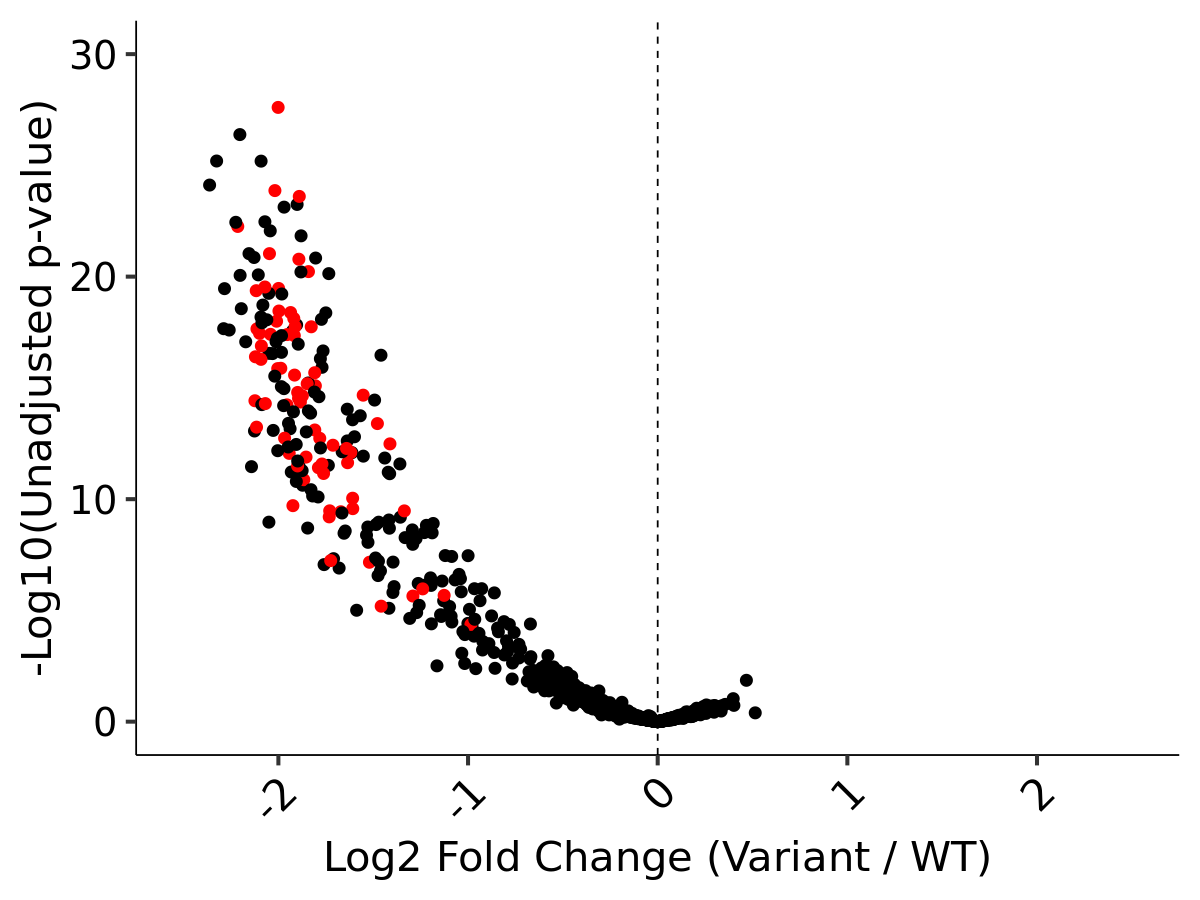

In [10]:
options(repr.plot.height = 7.5, repr.plot.width = 10)
ggplot(sumstats %>% 
           filter(clone == "c8" & condition == "IFNa - Untreated") %>%
           mutate(aa = if_else(aa == "*", "Stop", aa))) +
        geom_point(aes(x = estimate/log(2), y = -log10(p.value),
                       color = if_else(aa == "Stop", "red", "black")), size = 3) +
        theme_pubr(base_size = 25, x.text.angle = 45) +
        theme(legend.text=element_text(size=23),
              legend.key.size = unit(1,"cm"),
              axis.text.y = element_text(size = 23)) +
        ylab("") + xlab("Log2 Fold Change (Variant / WT)") + ylab("-Log10(Unadjusted p-value)") +
        xlim(c(-2.5, 2.5)) + ylim(c(0,30)) +
        geom_vline(xintercept = 0, lty = 2) +
        scale_color_identity()

Alternatively, we can use heatmaps which show the Z-statistic for each comparison. The Z-statistic is the estimated effect size (here, it is the log fold change) divided by the standard error of that estimate. Note the scale - the limits are -30 and +10, which are _extremely_ significant effects:

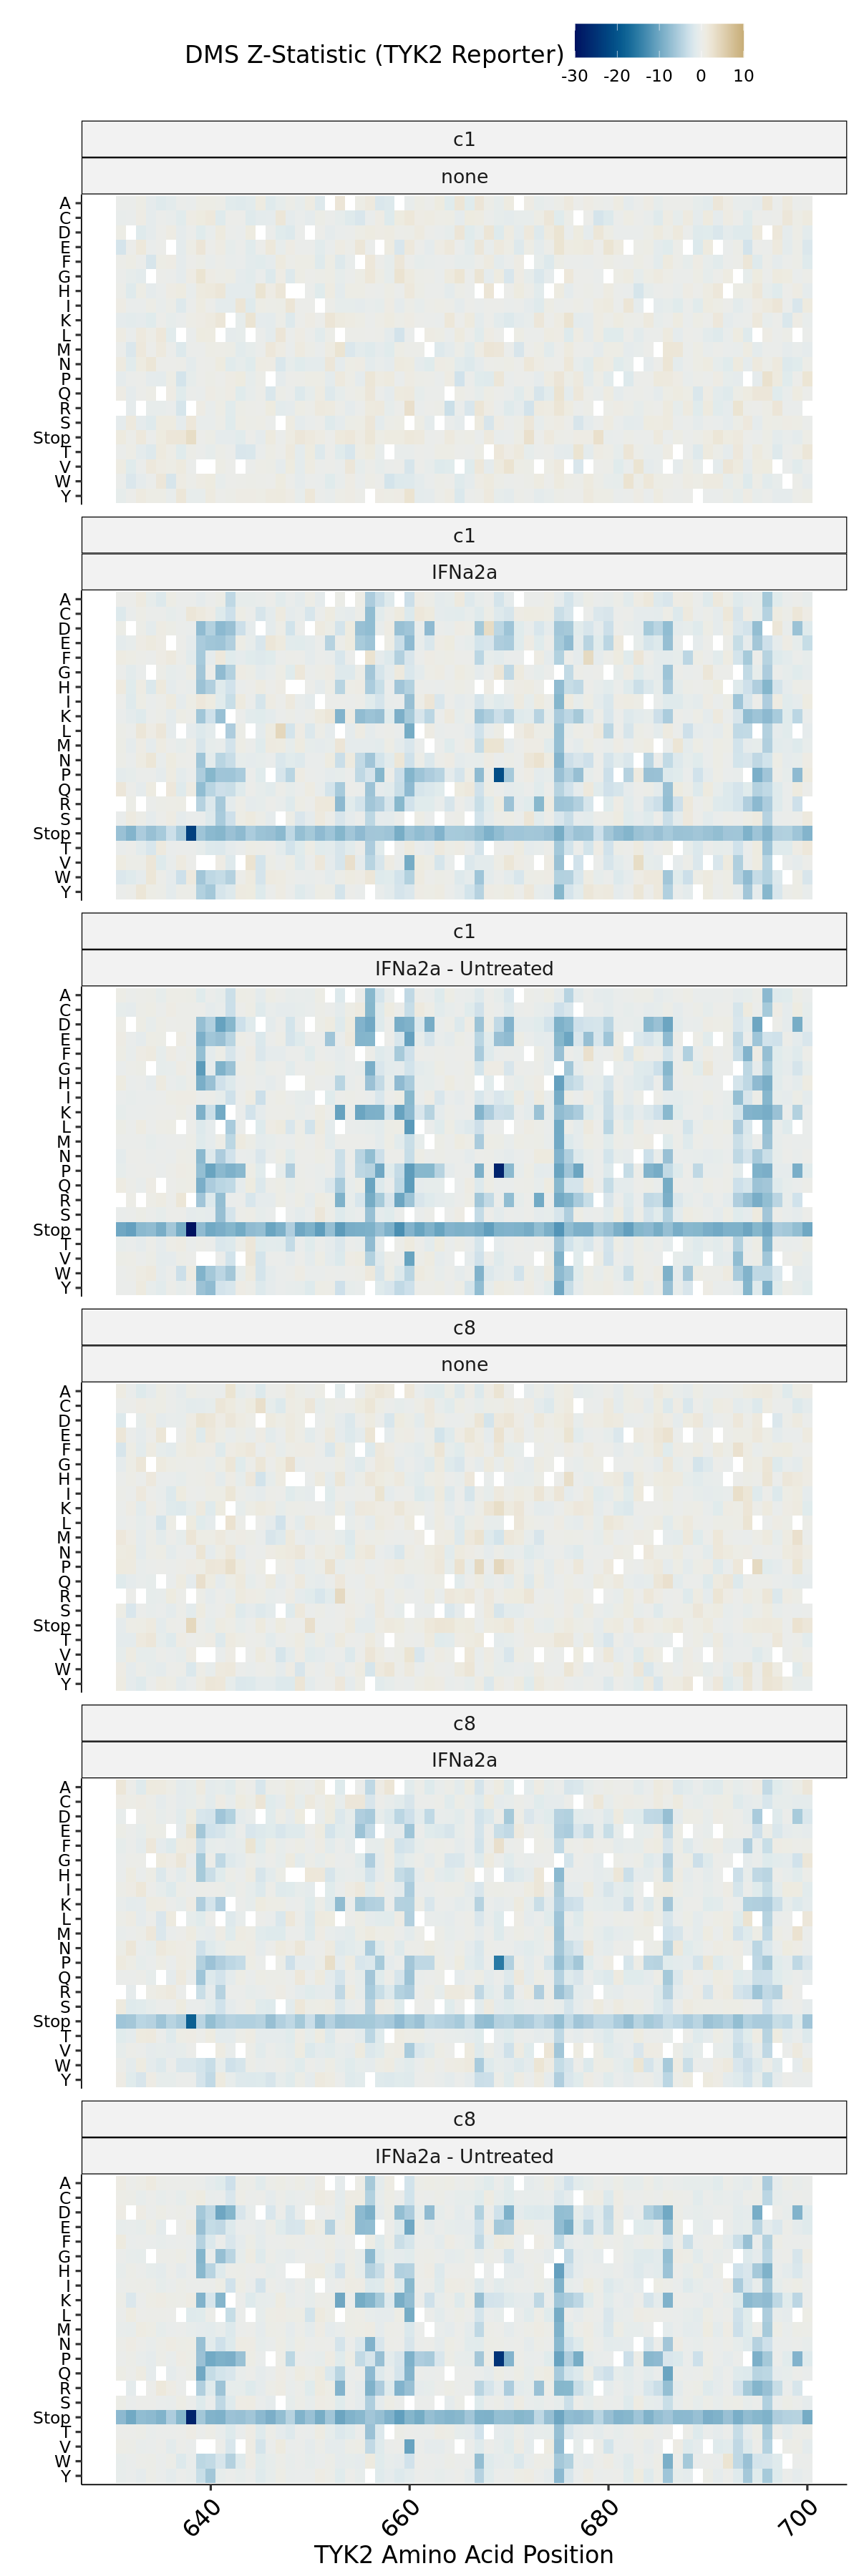

In [38]:
options(repr.plot.height = 30, repr.plot.width = 10)
ggplot(sumstats %>% 
           mutate(aa = if_else(aa == "*", "Stop", aa)) %>%
           #mutate(aa = factor(aa, levels = aalevels)) %>%
           rename("DMS Z-Statistic (TYK2 Reporter)" = statistic)) +
        geom_tile(aes(x = pos, y = fct_rev(aa), fill = `DMS Z-Statistic (TYK2 Reporter)`)) +
        scale_fill_scico_mid(palette = "vik", mid = 0, limits = c(-30,10), oob = squish) +
        theme_pubr(base_size = 20, x.text.angle = 45) +
        theme(legend.text=element_text(size=14),
              legend.key.size = unit(1,"cm"),
              axis.text.y = element_text(size = 14)) +
        facet_wrap(~clone + condition, ncol = 1) +
        ylab("") + xlab("TYK2 Amino Acid Position")

We can also make the same plot using the log fold change values, for a different perspective on the same pattern:

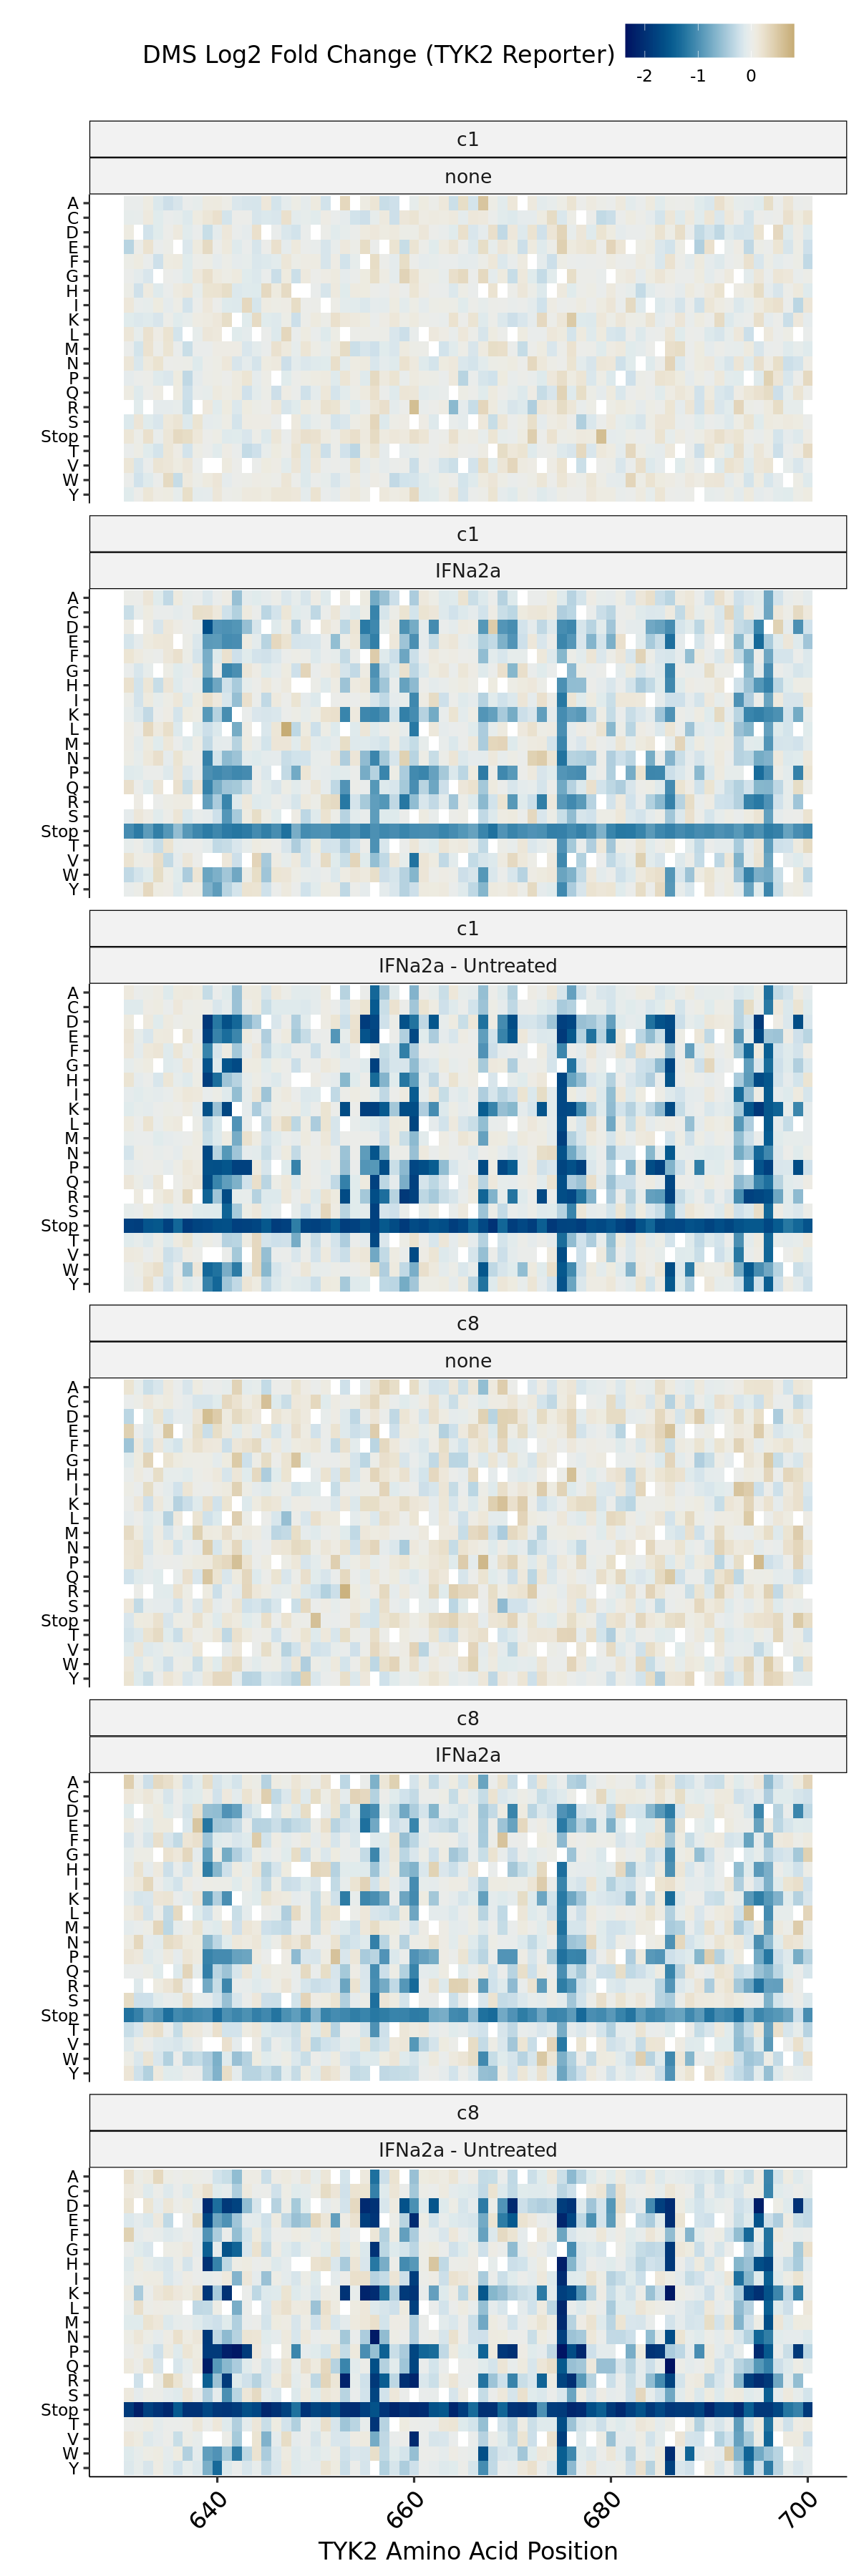

In [40]:
options(repr.plot.height = 30, repr.plot.width = 10)
ggplot(sumstats %>% 
           mutate(aa = if_else(aa == "*", "Stop", aa),
                  estimate = estimate / log(2)) %>%
           #mutate(aa = factor(aa, levels = aalevels)) %>%
           rename("DMS Log2 Fold Change (TYK2 Reporter)" = estimate)) +
        geom_tile(aes(x = pos, y = fct_rev(aa), fill = `DMS Log2 Fold Change (TYK2 Reporter)`)) +
        scale_fill_scico_mid(palette = "vik", mid = 0, oob = squish) +
        theme_pubr(base_size = 20, x.text.angle = 45) +
        theme(legend.text=element_text(size=14),
              legend.key.size = unit(1,"cm"),
              axis.text.y = element_text(size = 14)) +
        facet_wrap(~clone + condition, ncol = 1) +
        ylab("") + xlab("TYK2 Amino Acid Position")

This is broadly consistent with our expectations from the model, namely that we capture substantial additional power by using random intercepts, but that the underlying pattern is consistent even if we completely each dataset by treatment condition and then compare only after the fact.

In [43]:
## SVG form of heatmap
library(svglite)
svglite("TYK2-chunk10-heatmap-log2.svg", width = 10, height = 30)
ggplot(sumstats %>% 
           mutate(aa = if_else(aa == "*", "Stop", aa),
                  estimate = estimate / log(2)) %>%
           #mutate(aa = factor(aa, levels = aalevels)) %>%
           rename("DMS Log2 Fold Change (TYK2 Reporter)" = estimate)) +
        geom_tile(aes(x = pos, y = fct_rev(aa), fill = `DMS Log2 Fold Change (TYK2 Reporter)`)) +
        scale_fill_scico_mid(palette = "vik", mid = 0, oob = squish) +
        theme_pubr(base_size = 20, x.text.angle = 45) +
        theme(legend.text=element_text(size=14),
              legend.key.size = unit(1,"cm"),
              axis.text.y = element_text(size = 14)) +
        facet_wrap(~clone + condition, ncol = 1) +
        ylab("") + xlab("TYK2 Amino Acid Position")
dev.off()

png 
  2

We can also grab the conservation scores at the residue level from ConSurf, for comparison in this chunk:

In [46]:
conserv <- read_delim("../data/annotations/TYK2-conservation-consurf.txt") %>%
    select(POS:SCORE,COLOR,CONFIDENCEINTERVAL) %>%
    rename("pos" = "POS",
           "wt_aa" = "SEQ",
           "Conservation Score" = "SCORE",
           "class" = "COLOR",
           "interval" = "CONFIDENCEINTERVAL") %>%
    separate(interval, c("lower_bound", "upper_bound"), ",") %>%
    mutate(`Conservation Score` = -as.numeric(`Conservation Score`),
           lower_bound = as.numeric(lower_bound),
           upper_bound = as.numeric(upper_bound))

New names:
• `` -> `...4`
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 1187 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): SEQ, COLOR, CONFIDENCEINTERVAL, MSADATARESIDUEVARIETY
dbl (2): POS, SCORE
num (1): FUNCTION
lgl (3): ...4, CONFIDENCEINTERVALCOLORS, B/E

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


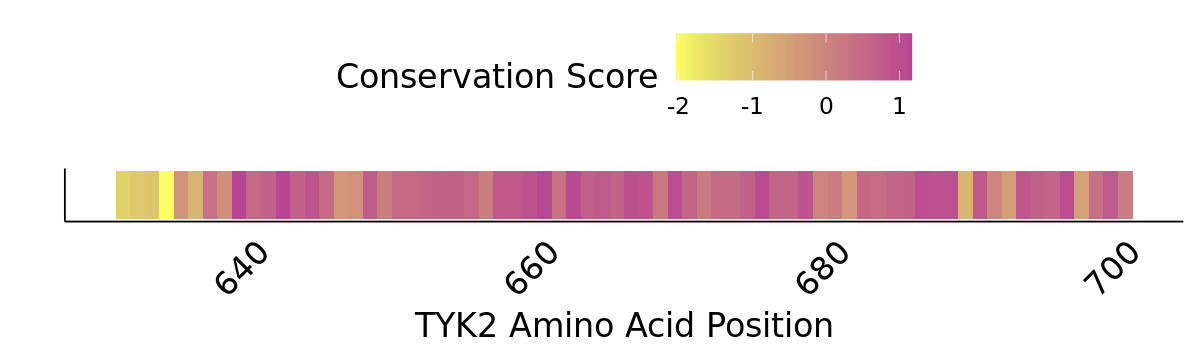

In [64]:
options(repr.plot.height = 3, repr.plot.width = 10)
ggplot(conserv %>% filter(pos >= 631, pos <= 700)) +
        geom_tile(aes(x = pos, y = 0, fill = `Conservation Score`)) +
        scale_fill_scico_mid(palette = "buda", mid = 0, oob = squish, direction = -1) +
        theme_pubr(base_size = 20, x.text.angle = 45) +
        theme(legend.text=element_text(size=14),
              legend.key.size = unit(1,"cm"),
              axis.text.y = element_blank(),
              axis.ticks = element_blank()) +
        ylab("") + xlab("TYK2 Amino Acid Position")